In [566]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision
from torchvision import transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import cv2

In [519]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize all images to 150x15
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
])

In [520]:
dataset = datasets.ImageFolder(root='dataset', transform=transform)
train_len = int(0.7 * len(dataset))  # 70% for training
val_len = int(0.15 * len(dataset))  # 15% for validation
test_len = len(dataset) - train_len - val_len  # 15% for testing

# Create the training, validation and test datasets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

# Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [521]:
print(dataset.classes)
classes = dataset.classes
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

['busy', 'free']
8808
1887
1889


In [540]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [523]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

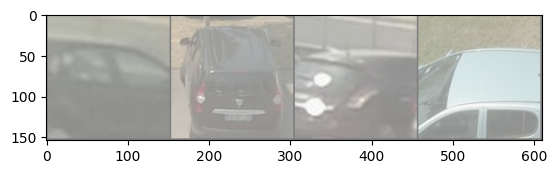

 free  busy  busy  busy


In [524]:
# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [525]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 4, 32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 16, 5)
        self.fc1 = nn.Linear(11664, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 84)
        self.fc5 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


net = Net()

In [526]:
# Initialize the model
model = Net().to(device)
print(model)


Net(
  (conv1): Conv2d(3, 4, kernel_size=(32, 32), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=11664, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=84, bias=True)
  (fc5): Linear(in_features=84, out_features=2, bias=True)
)


In [527]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss()

In [528]:
# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [529]:
# Define the training loop
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [531]:
# Train the model
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(val_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 0.695202  [    0/ 8808]
loss: 0.700498  [  400/ 8808]
loss: 0.449658  [  800/ 8808]
loss: 0.587806  [ 1200/ 8808]
loss: 0.572455  [ 1600/ 8808]
loss: 0.311911  [ 2000/ 8808]
loss: 0.654004  [ 2400/ 8808]
loss: 0.480255  [ 2800/ 8808]
loss: 0.003459  [ 3200/ 8808]
loss: 0.644737  [ 3600/ 8808]
loss: 1.095659  [ 4000/ 8808]
loss: 0.229677  [ 4400/ 8808]
loss: 0.199220  [ 4800/ 8808]
loss: 0.406760  [ 5200/ 8808]
loss: 0.504767  [ 5600/ 8808]
loss: 0.250287  [ 6000/ 8808]
loss: 0.681246  [ 6400/ 8808]
loss: 1.651367  [ 6800/ 8808]
loss: 0.297787  [ 7200/ 8808]
loss: 0.275683  [ 7600/ 8808]
loss: 0.098885  [ 8000/ 8808]
loss: 0.247730  [ 8400/ 8808]
loss: 0.190495  [ 8800/ 8808]
Test Error: 
 Accuracy: 68.6%, Avg loss: 0.136025 

Epoch 2
-------------------------------
loss: 0.785312  [    0/ 8808]
loss: 0.075117  [  400/ 8808]
loss: 0.005038  [  800/ 8808]
loss: 0.224057  [ 1200/ 8808]
loss: 0.266916  [ 1600/ 8808]
loss: 0.567677  [ 2000/ 8808

In [532]:
# Save the model
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [546]:
# Load the model
model = Net()
model.load_state_dict(torch.load("model.pth"))
model.to(device)  # Move the model to the GPU if available
model.eval()

Net(
  (conv1): Conv2d(3, 4, kernel_size=(32, 32), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=11664, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=84, bias=True)
  (fc5): Linear(in_features=84, out_features=2, bias=True)
)

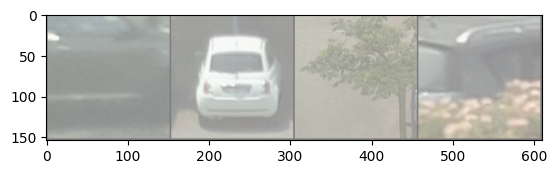

GroundTruth:  free  busy  free  busy 


In [561]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [557]:
PATH = 'model.pth'
net = Net()
net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [562]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  free  busy  free  busy 


In [573]:
from PIL import Image

image = cv2.imread('poza1.jpeg')
image = Image.fromarray(image)
image = transform(image)
image = image.unsqueeze(0)
outputs = net(image)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', f'{classes[predicted[0]]:5s}')


Predicted:  busy 
